In [109]:
import tiktoken
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn

In [110]:
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [111]:
# Memory-map the training dataset file into numpy array (uint32).
# train_data = np.memmap('../preprocess_data/train.bin', dtype=np.uint32, mode='r')

# # Memory-map the validation dataset file.
# val_data = np.memmap('../preprocess_data/validation.bin', dtype=np.uint32, mode='r')

In [112]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [113]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [114]:
def dataloader(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True, num_workers=0):
    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader


In [115]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.0,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}      

In [116]:
train_loader = dataloader(train_data,
                          batch_size=2,
                          max_length=GPT_CONFIG_124M["context_length"],
                          stride=GPT_CONFIG_124M["context_length"],
                          shuffle=True,
                          drop_last=True,
                          num_workers=0)

val_loader = dataloader(val_data,
                        batch_size=2,
                        max_length=GPT_CONFIG_124M["context_length"],
                        stride=GPT_CONFIG_124M["context_length"],
                        shuffle=False,
                        drop_last=True,
                        num_workers=0)  

In [117]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length, drop_rate=0.0, qkv_bias=False):
        super().__init__()
        assert d_out % n_heads == 0, "d_out must be divisible by n_heads"
        self.d_out = d_out
        self.n_heads = n_heads
        self.head_dim = d_out // n_heads
        
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )
        
        self.attn_drop = nn.Dropout(drop_rate)
        self.proj_out = nn.Linear(d_out, d_out)
        
    def forward(self, x):
        B, T, C = x.shape
        
        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)    
        
        queries = queries.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)
        values = values.view(B, T, self.n_heads, self.head_dim).transpose(1, 2)   
        
        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores.masked_fill_(
            self.mask.bool()[:T, :T], -torch.inf
        )
        attn_scores = attn_scores / (keys.shape[-1] ** 0.5)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.attn_drop(attn_weights)
        
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(B, T, self.d_out)
        
        context_vec = self.proj_out(context_vec)
        return context_vec
        

In [118]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_norm + self.shift

In [119]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [120]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [121]:
class TranformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.ln1 = LayerNorm(cfg["emb_dim"])
        self.mha = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            n_heads=cfg["n_heads"],
            context_length=cfg["context_length"],
            drop_rate=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ln2 = LayerNorm(cfg["emb_dim"])
        self.ff = FeedForward(cfg)
        self.drop = nn.Dropout(cfg["drop_rate"])
        
    def forward(self, x):
        x = x + self.drop(self.mha(self.ln1(x)))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x

In [122]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emd = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        
        self.drop = nn.Dropout(cfg["drop_rate"])
        
        self.transformer_blocks = nn.Sequential(
            * [TranformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        
        self.ln_f = LayerNorm(cfg["emb_dim"])
        
        self.out_proj = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
        
    def forward(self, input_ids):
        B, T = input_ids.shape
        
        tok_emb = self.tok_emb(input_ids)
        pos_emb = self.pos_emd(torch.arange(T, device=input_ids.device))
        
        x = self.drop(tok_emb + pos_emb)
        x = self.transformer_blocks(x)
        x = self.ln_f(x)
        
        logits = self.out_proj(x)
        
        return logits

In [123]:
model = GPTModel(GPT_CONFIG_124M)

In [124]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [125]:

start_context = "Hello, I am"
tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [126]:

model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 34239, 28245, 43327, 20977, 33555, 34997]])
Output length: 10


In [127]:

decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I amgres Baylorjump‑ Manor Procedure


In [128]:

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [129]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [130]:

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calculate_loss(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

    return train_losses, val_losses, track_tokens_seen

In [ ]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [ ]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
)

Ep 1 (Step 000000): Train loss 9.927, Val loss 10.045
Ep 1 (Step 000005): Train loss 8.172, Val loss 8.470
Ep 2 (Step 000010): Train loss 6.630, Val loss 7.096
Ep 2 (Step 000015): Train loss 5.986, Val loss 6.567
Ep 3 (Step 000020): Train loss 5.458, Val loss 6.436
Ep 3 (Step 000025): Train loss 5.347, Val loss 6.402
Ep 4 (Step 000030): Train loss 5.306, Val loss 6.499
Ep 4 (Step 000035): Train loss 5.017, Val loss 6.352
Ep 5 (Step 000040): Train loss 4.357, Val loss 6.339
Ep 6 (Step 000045): Train loss 4.165, Val loss 6.273
Ep 6 (Step 000050): Train loss 3.706, Val loss 6.260
Ep 7 (Step 000055): Train loss 3.679, Val loss 6.240
Ep 7 (Step 000060): Train loss 2.895, Val loss 6.119
Ep 8 (Step 000065): Train loss 2.402, Val loss 6.191
Ep 8 (Step 000070): Train loss 2.037, Val loss 6.202
Ep 9 (Step 000075): Train loss 1.663, Val loss 6.192
Ep 9 (Step 000080): Train loss 1.272, Val loss 6.282
Ep 10 (Step 000085): Train loss 0.946, Val loss 6.318


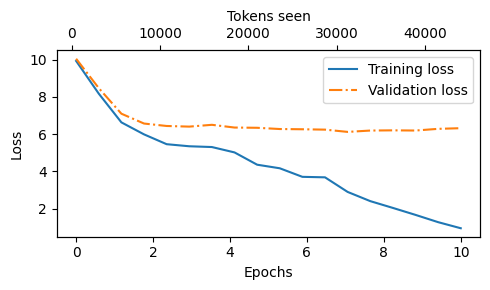

In [133]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [134]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [135]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [136]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [137]:
model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony.












